In [ ]:
#Import required libraries
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from skimage.transform import resize
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split
from collections import Counter
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn import metrics
import time
from sklearn.metrics import accuracy_score,recall_score,precision_score, f1_score

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Google Drive path where coursework material is available
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_Computer_vision/CV_Coursework/CW_Folder_PG_template/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['test_functions.ipynb', 'Models', 'Video', 'CW_Dataset', 'Code', 'Test_functions_video.ipynb', 'Copy of test_functions.ipynb', 'FaceDetectionVideo_using_CNN_MObilenet.ipynb', 'test_functions_v3.ipynb', 'Report template.docx']


In [ ]:
import torch
device = torch.device('cpu')
# Code should run on cpu
print(device)

cpu


In [ ]:
#Magic comand to load for automatic loading of modules
#Adapted from Lab
%load_ext autoreload
%autoreload 2

In [ ]:
#import modules located in code directory
#adapted from Lab
import sys
CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code')
sys.path.append(CODE_PATH)

In [ ]:
#extracted data from zipped file to copy in Colab
#Code adapted from the lab
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

  # Copy it to Colab
!cp '{zip_path}' .
  # Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip


In [ ]:
#import required functions from Load_data python script to load data
from Load_data import FileNameList,Fetch_text_data, Fetch_images
#FileNameList is the function to collect all the filnames (images and labels)
#Fetch_text_data is a funtion to import all label names from labels folder into the list
#Fetch_images is a function to import all the images from images folder

In [ ]:
test_label_data = Fetch_text_data('test/labels',FileNameList('test/labels','.txt')) #import test labels
train_label_data = Fetch_text_data('train/labels',FileNameList('train/labels','.txt')) # import train labels
test_images_data = Fetch_images('test/images',FileNameList('test/images', '.jpeg')) #import test images
train_images_data = Fetch_images('train/images',FileNameList('train/images', '.jpeg')) #import train images

In [ ]:
num_classes = len(set(train_label_data))
num_classes

3

[MobileNetv2 Architecture](https://research.google/blog/mobilenetv2-the-next-generation-of-on-device-computer-vision-networks/)

**MobileNetV2 is used for Transfer learning**
This paper defines architecture of MobileNetV2 using this as it used bottleneck methodology and is less complex. We have used this pre-trained model fine tune our CNN model.

In [ ]:
from torchvision import models, transforms
mobileNet_model = models.mobilenet_v2(weights='IMAGENET1K_V1') #create mobileNetv2 model instance which uses pre-trained weights from ImageNet datset


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]


In [ ]:
num_features = mobileNet_model.classifier[1].in_features #last layer features
print(num_features)

1280


In [ ]:
#replace last fully connected layer with new layer with where input features are num_features and produces 3 output
mobileNet_model.classifier[1] = nn.Linear(num_features, num_classes)

In [ ]:
# Define the data transformations which are usually considered when use transer learning
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define a dataset class ( this will be used to create dataloader)
from torch.utils.data import Dataset, DataLoader
class Mask_Dataset(Dataset):
    def __init__(self, inputs, targets, transform=None):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        target = int(self.targets[idx])
        if self.transform:
            input_data = self.transform(input_data)
        return input_data, target

In [ ]:
# # Not using random division of train and validation data as data is not balanced
# train_dataset = Mask_Dataset(train_images_data, train_label_data, transform=transform)
# train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
# test_dataset = Mask_Dataset(test_images_data, test_label_data, transform=transform)

In [ ]:
# Create the dataset
dataset = Mask_Dataset(train_images_data, train_label_data, transform=transform)
#refered from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
#stratified splitting : as data is unbalanced
required_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(required_split.split(train_images_data, train_label_data))

#train and validation dataset with its inputs and target variables
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

#Test dataset with its inputs and target variables
test_dataset = Mask_Dataset(test_images_data, test_label_data, transform=transform)

In [ ]:
#Distribution of data in train and validation dataset
# labels for target variables
labels_train= [train_label_data[i] for i in train_idx]
labels_val = [train_label_data[i] for i in val_idx]

# Count of taret variables
train_counts = Counter(labels_train)
val_counts = Counter(labels_val)

# Print the counts of each class in train and validation dataset
print("Train label counters:")
for label, count in train_counts.items():
    print(f"Label {label}: {count} ")

print("Validation label counters:")
for label, count in val_counts.items():
    print(f"Label {label}: {count} ")

Train label counters:
Label 1: 1552 
Label 0: 301 
Label 2: 62 
Validation label counters:
Label 1: 388 
Label 0: 75 
Label 2: 16 


In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32,shuffle=True) #dataloaders to be used during trainig, validation and testing
val_dataloader = DataLoader(dataset=val_dataset,batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# test_loader.dataset.inputs[1]
for images, labels in test_loader: #to quick check image shape when used in batches
  print(images.shape)
  break

torch.Size([32, 3, 224, 224])


In [ ]:
mobileNet_model = mobileNet_model.to(device) #assign model to cpu

In [ ]:
#define hyper parameters, these were obtained after experimenting with different values
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(mobileNet_model.parameters(), lr=0.003, momentum =0.9, weight_decay=0.01)
#optimizer = optim.Adam(mobileNet_model.parameters(), lr=0.003, weight_decay=0.01)
#optimizer =optim.Adam(mobileNet_model.parameters(), lr=0.001)
optimizer =optim.Adam(mobileNet_model.parameters(), lr=0.0003, weight_decay=0.001)
# optimizer =optim.Adam(mobileNet_model.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
epochs = 10


Epoch [1/10], Training Loss: 0.22
Epoch [1 of 10], Validation Loss: 0.11
Epoch [2/10], Training Loss: 0.09
Epoch [2 of 10], Validation Loss: 0.17
Epoch [3/10], Training Loss: 0.04
Epoch [3 of 10], Validation Loss: 0.13
Epoch [4/10], Training Loss: 0.02
Epoch [4 of 10], Validation Loss: 0.13
Epoch [5/10], Training Loss: 0.01
Epoch [5 of 10], Validation Loss: 0.11
Epoch [6/10], Training Loss: 0.03
Epoch [6 of 10], Validation Loss: 0.19
Early stopping at epoch 6
Best Model
Training completed in 45m 28s


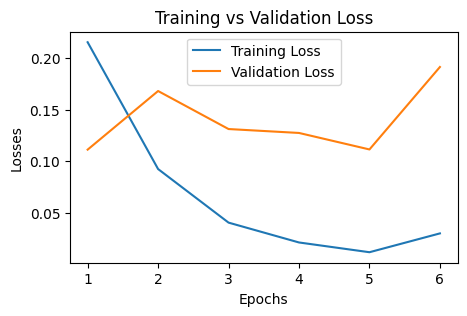

In [ ]:
# Train the model
best_val_loss = 100 # highest can be 100% so using 100 to compare
state_dict_best_model = None
loss_train = []
loss_val = []
patience = 5  # num epochs to wait for improvement
counter_earlyStop = 0
time0= time.time()
for epoch in range(epochs):
    mobileNet_model.train()
    total_batch_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = mobileNet_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_batch_loss =total_batch_loss+ loss.item()

    #average training loss for the epoch
    epoch_loss_train = total_batch_loss / len(train_dataloader)
    loss_train.append(epoch_loss_train)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss_train:.2f}")

    # Validation
    mobileNet_model.eval()
    total_batch_loss_val = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = mobileNet_model(images)
            loss = criterion(outputs, labels)
            total_batch_loss_val =total_batch_loss_val+ loss.item()

    # Calculate and store the average validation loss for the epoch
    epoch_loss_val = total_batch_loss_val / len(val_dataloader)
    loss_val.append(epoch_loss_val)
    print(f"Epoch [{epoch+1} of {epochs}], Validation Loss: {epoch_loss_val:.2f}")

    # save best model which has least validation loss
    if epoch_loss_val < best_val_loss:
        best_val_loss = epoch_loss_val
        state_dict_best_model = mobileNet_model.state_dict()

        early_stop_counter = 0  # Reset early counter if the loss after 5 itteration improved
    else:
        counter_earlyStop =counter_earlyStop + 1
        if counter_earlyStop >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Save the best model
if state_dict_best_model is not None:
  print('Best Model')

  #torch.save(mobileNet_model.state_dict(), 'drive/My Drive/My_Computer_vision/CV_Coursework/CW_Folder_PG_template/CW_Folder_PG/Models/cnn_MobileNet_final.pth')
time1 = time.time()
elapsed_time =time1-time0
print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
# plot training and validation vs epocs
epochs_range = range(1, len(loss_train) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs_range, loss_train, label='Training Loss')
plt.plot(epochs_range, loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

**Evaluation after Loading the best model which was saved during modelling.**

In [ ]:
#load the mobileNet model architecture without weights
CNNmodel_mobileNet= models.mobilenet_v2(weights=None)

In [ ]:
num_classes = 3  # Replace with the desired number of output classes
num_features = CNNmodel_mobileNet.classifier[1].in_features
CNNmodel_mobileNet.classifier[1] = nn.Linear(num_features, num_classes) #replace last layer of mobileNetv2 with three neurons( as our number of labels are three)

In [ ]:
model_path = 'drive/My Drive/My_Computer_vision/CV_Coursework/CW_Folder_PG_template/CW_Folder_PG/Models/cnn_MobileNet_final.pth' # direct model path

In [ ]:
state_dict = torch.load(model_path) #load the dictionary of our trained model ( it will have weights, bias values)


In [ ]:
CNNmodel_mobileNet.load_state_dict(state_dict) #load the dict on the mobileNetV2 architecture , this is our trained model now which we will use to train

<All keys matched successfully>

In [ ]:
device = torch.device("cpu") #define device as cpu

In [ ]:
# evaluate on test data
start_time = time.time()
mobileNet_model.eval()
with torch.no_grad():
        y_predict = []
        y = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = CNNmodel_mobileNet(images)
            _, predicted = torch.max(outputs.data, 1)
            y_predict.extend(predicted.cpu().numpy())
            y.extend(labels.cpu().numpy())

        test_acc = accuracy_score(y, y_predict)
        print(f"Test Accuracy is {test_acc*100:.2f}%")
end_time  = time.time()
elapsed_time = end_time-start_time
print(f"Testing completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Test Accuracy is 96.72%
Testing completed in 0m 50s


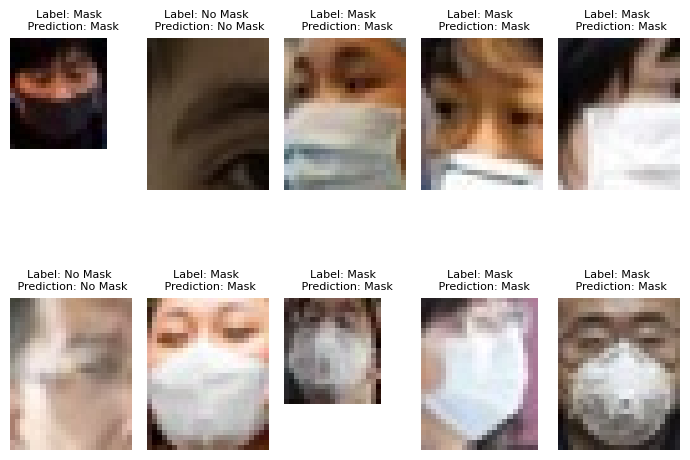

In [ ]:
#display 10 images with their true and predicted labels
#Code partially adapted from Lab
images, label, y = shuffle(test_loader.dataset.inputs, y, y_predict)
fig, axes = plt.subplots(2, 5, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()
dict = {1: 'Mask', 2: 'Incorrect Mask', 0: 'No Mask'}


for i in range(10):
    ax[i].imshow(images[i])
    ax[i].set_title(f'Label: {dict[label[i]]} \n Prediction: {dict[y[i]]}', fontsize =8)
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

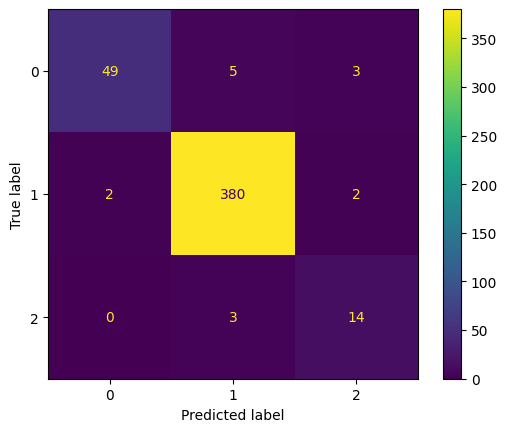

In [ ]:
#plot confusion matrix to compare true and predicted label differneces
metrics.ConfusionMatrixDisplay.from_predictions(y, y_predict)
plt.show()

In [ ]:
#Weighted performance metrics for three label class
print(f'Accuracy: {accuracy_score(y, y_predict)}')
print(f'F1 score: {f1_score(y, y_predict, average="weighted")}')
print(f'recall: {recall_score(y, y_predict,average="weighted")}')
print(f'precision:{precision_score(y, y_predict,average="weighted")}')

Accuracy: 0.9672489082969432
F1 score: 0.967167754936515
recall: 0.9672489082969432
precision:0.9677578554248217


In [ ]:
#________________________________End Transfer learning CNN MobileNetv2 model___________________________________________